In [1]:
import torch
from torch.utils.data import DataLoader
from datasets import Dataset
import random
import copy
import itertools
import numpy as np
from tqdm import tqdm, trange

from sklearn.metrics import classification_report
from transformers import get_linear_schedule_with_warmup

import pyvene
from pyvene import CausalModel
from pyvene.models.mlp.modelings_mlp import MLPConfig
from pyvene import create_mlp_classifier
from pyvene import (
    IntervenableModel,
    VanillaIntervention,
    RotatedSpaceIntervention,
    LowRankRotatedSpaceIntervention,
    RepresentationConfig,
    IntervenableConfig,
)

In [2]:
seed = 42
np.random.seed(seed)
random.seed(seed)
torch.manual_seed(seed)

## Causal model

Sum 3 vectors. Mean positive -> True, Negative -> False

In [3]:
embedding_dim = 2
number_of_entities = 20

def randvec(n=50, lower=-1, upper=1):
    return np.array([round(random.uniform(lower, upper), 2) for i in range(n)])

def all_possible_sums(values1, values2):
    l = list(itertools.product(values1, values2))
    return [sum(i) for i in l]

# variables
variables = ['X', 'Y', 'Z', 'S1', 'W', 'S2']

# all possible values of variables
reps = [randvec(embedding_dim, lower=-1, upper=1) for _ in range(number_of_entities)]
values = {variable: reps for variable in ['X', 'Y', 'Z']}
values['W'] = values['Z']
values['S1'] = all_possible_sums(values['X'], values['Y'])
values['S2'] = [True, False]

# parents
parents = {
    'X': [],
    'Y': [],
    'Z': [],
    'S1': ['X', 'Y'],
    'W': ['Z'],
    'S2': ['S1', 'W'],
}

# functions
def FILLER():
    return reps[0]

# function at each node
functions = {
    'X': FILLER,
    'Y': FILLER,
    'Z': FILLER,
    # inputs are all the parents (children if arrows are reversed)
    'S1': lambda x, y: x + y,
    'W': lambda x: x,
    'S2': lambda x, y: (x + y).mean()>=0,
}

# a dictionary with nodes as keys and positions as values
pos = {
    'X': (0.5, 0),
    'Y': (1.5, 0),
    'Z': (2.5, 0),
    'S1': (1.1, 1),
    'W': (2.2, 1),
    'S2': (1.7, 2),
}

In [4]:
sum_model = CausalModel(variables, values, parents, functions, pos=pos)

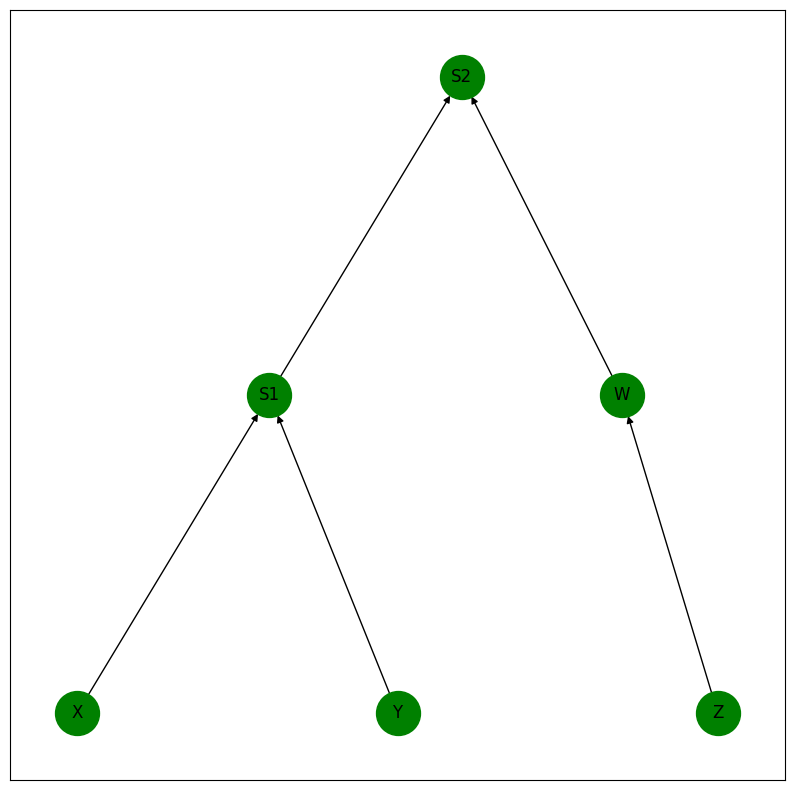

Timesteps: {'X': 0, 'Y': 0, 'Z': 0, 'S1': 1, 'W': 1, 'S2': 2}


In [5]:
sum_model.print_structure()
print("Timesteps:", sum_model.timesteps)

### No intervention

No intervention:
 defaultdict(None, {'X': array([ 0.28, -0.95]), 'Y': array([-0.45, -0.55]), 'Z': array([0.47, 0.35]), 'S1': array([-0.17, -1.5 ]), 'W': array([0.47, 0.35]), 'S2': False}) 



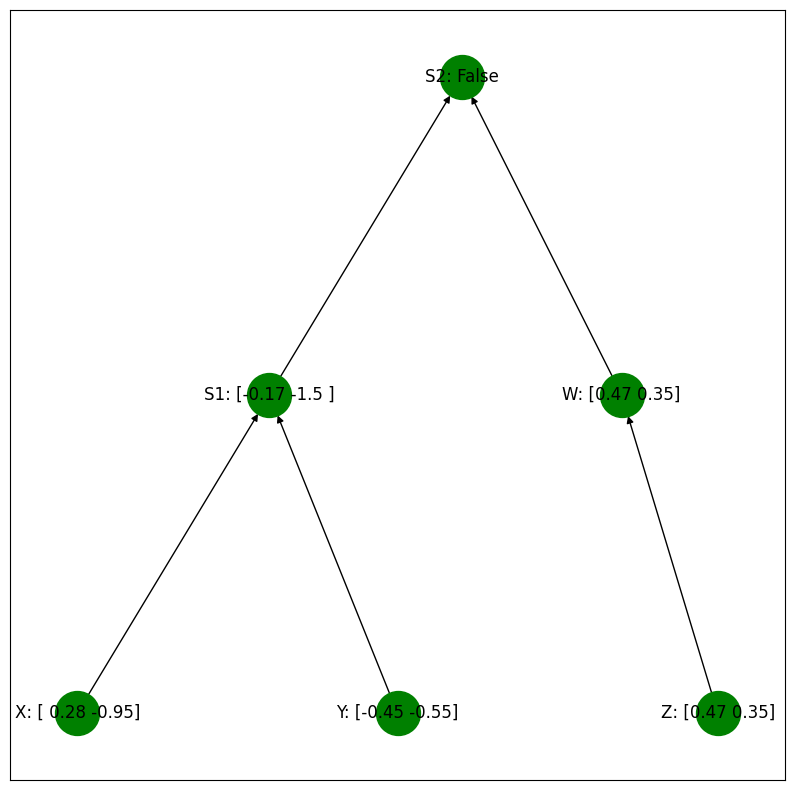

In [6]:
setting = sum_model.run_forward({'X': reps[0], 'Y': reps[1], 'Z': reps[2]})

print("No intervention:\n", setting, "\n")
sum_model.print_setting(setting)

### With intervention at S1

[ 0.78 -0.83] at S1
With intervention:
 defaultdict(None, {'X': array([ 0.28, -0.95]), 'Y': array([-0.45, -0.55]), 'Z': array([0.47, 0.35]), 'S1': array([ 0.78, -0.83]), 'W': array([0.47, 0.35]), 'S2': True}) 



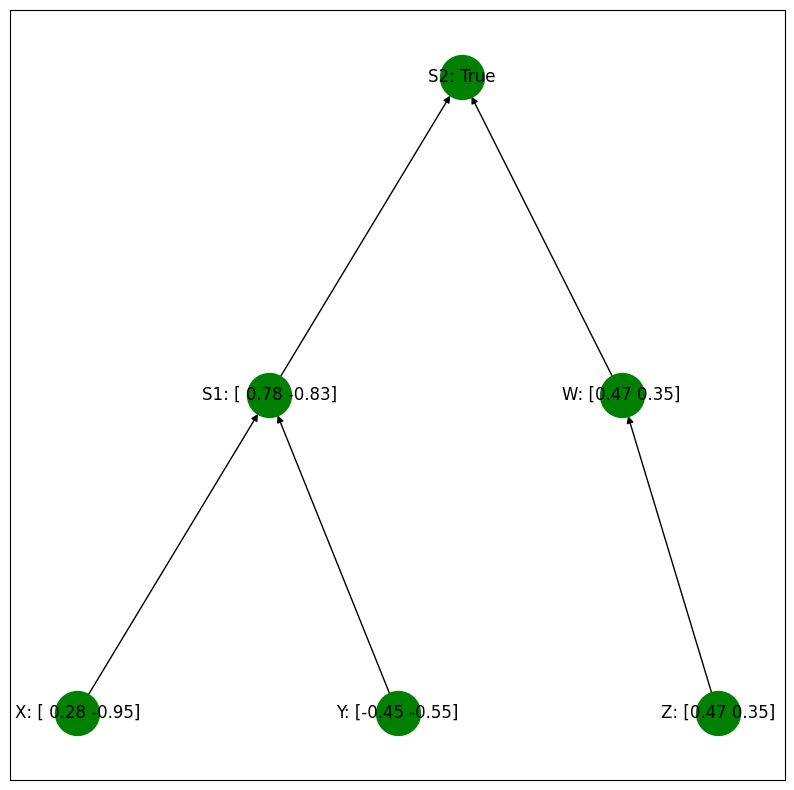

In [7]:
print("{} at S1".format(reps[3]))
setting = sum_model.run_forward({'X': reps[0], 'Y': reps[1], 'Z': reps[2], 'S1': reps[3]})

print("With intervention:\n", setting, "\n")
sum_model.print_setting(setting)

### Interchange intervention at S1

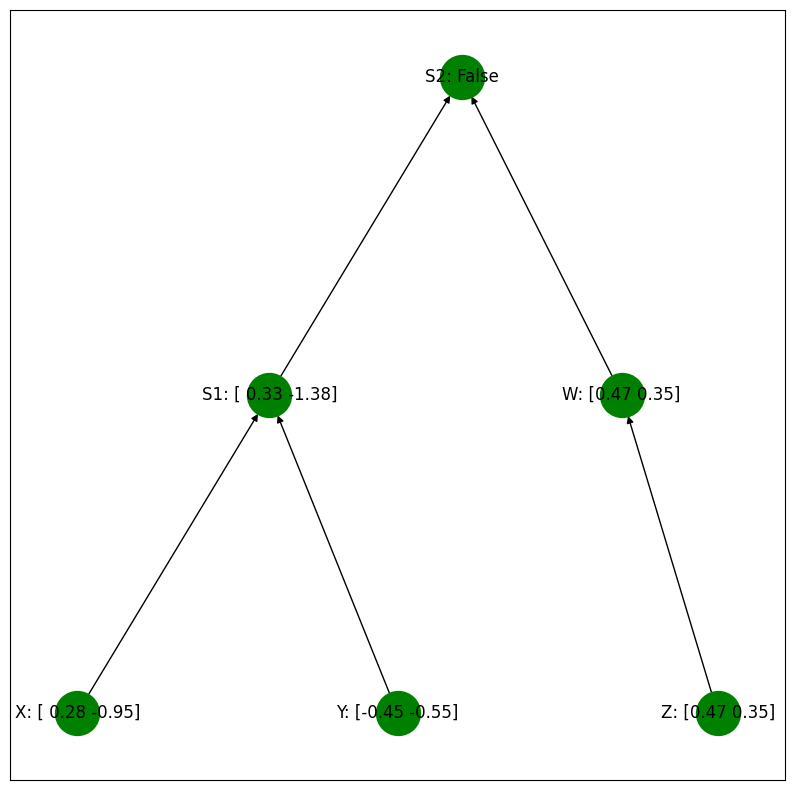

In [8]:
base = {'X': reps[0], 'Y': reps[1], 'Z': reps[2]}
source = {'X': reps[3], 'Y': reps[1], 'Z': reps[3]}

setting = sum_model.run_interchange(base, {'S1': source})
sum_model.print_setting(setting)

## Training an MLP

### Create sample dataset

In [9]:
# define an input sampler to provide an infinite stream of new entities,
# rather than relying on a fixed set of vector representations

def input_sampler():
    A = randvec(embedding_dim)
    B = randvec(embedding_dim)
    C = randvec(embedding_dim)
    x = random.randint(1, 3)
    if x == 1:
        return {"X": A, "Y": B, "Z": C}
    elif x == 2:
        return {"X": B, "Y": C, "Z": A}
    elif x == 3:
        return {"X": C, "Y": A, "Z": B}

In [10]:
n_examples = 1048576
batch_size = 1024

examples = sum_model.generate_factual_dataset(n_examples, input_sampler)
X = torch.stack([example['input_ids'] for example in examples])
y = torch.stack([example['labels'] for example in examples])

In [11]:
train_ds = Dataset.from_dict(
    {
        "labels": [
            torch.FloatTensor([0, 1]) if i == 1 else torch.FloatTensor([1, 0])
            for i in y
        ],
        "inputs_embeds": X,
    }
)

### Train 2 layer neural network for regression

In [15]:
config = MLPConfig(
    h_dim=embedding_dim * 3,
    activation_function="relu",
    n_layer=2,
    num_classes=2, 
    pdrop=0.0,
)
config, tokenizer, mlp_model = create_mlp_classifier(config)
mlp_model.train()

loaded model


MLPForClassification(
  (mlp): MLPModel(
    (dropout): Dropout(p=0.0, inplace=False)
    (h): ModuleList(
      (0-1): 2 x MLPBlock(
        (ff1): Linear(in_features=6, out_features=6, bias=True)
        (act): ReLU()
        (dropout): Dropout(p=0.0, inplace=False)
      )
    )
  )
  (score): Linear(in_features=6, out_features=2, bias=True)
)

In [16]:
from transformers import TrainingArguments, Trainer

training_args = TrainingArguments(
    output_dir="test_trainer",
    evaluation_strategy="epoch",
    learning_rate=0.001,
    num_train_epochs=3,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    report_to="none",
)

trainer = Trainer(
    model=mlp_model,
    args=training_args,
    train_dataset=train_ds,
    eval_dataset=train_ds,
    compute_metrics=lambda x: {
        "accuracy": classification_report(
            x[0].argmax(1), x[1].argmax(1), output_dict=True
        )["accuracy"]
    },
)

In [17]:
_ = trainer.train()

  0%|          | 0/3072 [00:00<?, ?it/s]

Could not estimate the number of tokens of the input, floating-point operations will not be computed


{'loss': 0.4303, 'grad_norm': 0.12786006927490234, 'learning_rate': 0.0008372395833333334, 'epoch': 0.49}
{'loss': 0.0745, 'grad_norm': 0.05543230473995209, 'learning_rate': 0.0006744791666666667, 'epoch': 0.98}


  0%|          | 0/1024 [00:00<?, ?it/s]

{'eval_loss': 0.04664529114961624, 'eval_accuracy': 0.9988899230957031, 'eval_runtime': 7.8531, 'eval_samples_per_second': 133523.636, 'eval_steps_per_second': 130.394, 'epoch': 1.0}
{'loss': 0.0387, 'grad_norm': 0.04370608553290367, 'learning_rate': 0.00051171875, 'epoch': 1.46}
{'loss': 0.0283, 'grad_norm': 0.03000718355178833, 'learning_rate': 0.00034895833333333334, 'epoch': 1.95}


  0%|          | 0/1024 [00:00<?, ?it/s]

{'eval_loss': 0.025205371901392937, 'eval_accuracy': 0.9992761611938477, 'eval_runtime': 8.0511, 'eval_samples_per_second': 130240.099, 'eval_steps_per_second': 127.188, 'epoch': 2.0}
{'loss': 0.0242, 'grad_norm': 0.034331150352954865, 'learning_rate': 0.00018619791666666665, 'epoch': 2.44}
{'loss': 0.0218, 'grad_norm': 0.0573006346821785, 'learning_rate': 2.34375e-05, 'epoch': 2.93}


  0%|          | 0/1024 [00:00<?, ?it/s]

{'eval_loss': 0.021543649956583977, 'eval_accuracy': 0.9992771148681641, 'eval_runtime': 7.5086, 'eval_samples_per_second': 139650.822, 'eval_steps_per_second': 136.378, 'epoch': 3.0}
{'train_runtime': 47.6389, 'train_samples_per_second': 66032.732, 'train_steps_per_second': 64.485, 'train_loss': 0.10103600635193288, 'epoch': 3.0}


Create a separate causal model with vector representations distinct from those used in training:

In [18]:
# variables
variables = ['X', 'Y', 'Z', 'S1', 'W', 'S2']

# all possible values of variables
reps = [randvec(embedding_dim, lower=-1, upper=1) for _ in range(number_of_entities)]
values = {variable: reps for variable in ['X', 'Y', 'Z']}
values['W'] = values['Z']
values['S1'] = all_possible_sums(values['X'], values['Y'])
values['S2'] = [True, False]

# parents
parents = {
    'X': [],
    'Y': [],
    'Z': [],
    'S1': ['X', 'Y'],
    'W': ['Z'],
    'S2': ['S1', 'W'],
}

# functions
def FILLER():
    return reps[0]

# function at each node
functions = {
    'X': FILLER,
    'Y': FILLER,
    'Z': FILLER,
    # inputs are all the parents (children if arrows are reversed)
    'S1': lambda x, y: x + y,
    'W': lambda x: x,
    'S2': lambda x, y: (x + y).mean()>=0,
}

# a dictionary with nodes as keys and positions as values
pos = {
    'X': (0.5, 0),
    'Y': (1.5, 0),
    'Z': (2.5, 0),
    'S1': (1.1, 1),
    'W': (2.2, 1),
    'S2': (1.7, 2),
}

test_sum_model = CausalModel(variables, values, parents, functions, pos=pos)

Check if trained model generalizes to test data

In [19]:
examples = test_sum_model.generate_factual_dataset(10000, input_sampler)
print("Test Results")

test_ds = Dataset.from_dict(
    {
        "labels": [
            torch.FloatTensor([0, 1]) if example['labels'].item() == 1 else torch.FloatTensor([1, 0])
            for example in examples
        ],
        "inputs_embeds": torch.stack([example['input_ids'] for example in examples]),
    }
)

test_preds = trainer.predict(test_ds)
y_test = [example['labels'].item() for example in examples]

print(classification_report(y_test, test_preds[0].argmax(1)))

Test Results


  0%|          | 0/10 [00:00<?, ?it/s]

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      4988
         1.0       1.00      1.00      1.00      5012

    accuracy                           1.00     10000
   macro avg       1.00      1.00      1.00     10000
weighted avg       1.00      1.00      1.00     10000



## Distributed Alignment Search

Assume the two high-level variables will be encoded in multidimensional linear subspaces of the first layer in the network. To learn these subspaces, we define an IntervenableConfig that allows us to target the first layer of in the network after it has been rotated by an orthogonal matrix:

In [20]:
config = IntervenableConfig(
    model_type=type(mlp_model),
    representations=[
        RepresentationConfig(
            0,  # layer
            "block_output",  # intervention type
            "pos",  # intervention unit is now aligned with tokens
            1,  # max number of unit
            subspace_partition=None,  # binary partition with equal sizes
            intervention_link_key=0,
        ),
        RepresentationConfig(
            0,  # layer
            "block_output",  # intervention type
            "pos",  # intervention unit is now aligned with tokens
            1,  # max number of unit
            subspace_partition=None,  # binary partition with equal sizes,
            intervention_link_key=0,
        ),
    ],
    intervention_types=RotatedSpaceIntervention,
)

In [21]:
intervenable = IntervenableModel(config, mlp_model, use_fast=True)
intervenable.set_device("cuda")
intervenable.disable_model_gradients()


In case multiple location tags are passed only the first one will be considered


### Create counterfactual dataset

In [22]:
# map intervention variable to some id
def intervention_id(intervention):
    if "S1" in intervention and "W" in intervention:
        return 2
    if "S1" in intervention:
        return 0
    if "W" in intervention:
        return 1


n_examples = 1280000
batch_size = 6400
#n_examples = 64
#batch_size = 16
# batch_size needed since dataset batched together in terms of intervention id
train_dataset = sum_model.generate_counterfactual_dataset(
    n_examples,
    intervention_id,
    batch_size,
    device="cuda:0",
    #device="cpu",
    sampler=sum_model.sample_input_tree_balanced,
)

In [23]:
print(train_dataset[0]["input_ids"])
print(train_dataset[0]["source_input_ids"])
print(train_dataset[0]["base_labels"])
print(train_dataset[0]["labels"])
print(train_dataset[0]["intervention_id"])

tensor([0.3000, 0.0900, 0.6900, 0.2100, 0.6100, 0.4600], device='cuda:0')
tensor([[-0.5600,  0.1800, -0.5600,  0.0100,  0.6100,  0.4000],
        [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000]],
       device='cuda:0')
tensor([1.], device='cuda:0')
tensor([1.], device='cuda:0')
tensor([0], device='cuda:0')


In [24]:
epochs = 10
gradient_accumulation_steps = 1
total_step = 0
target_total_step = len(train_dataset) * epochs

t_total = int(len(train_dataset) * epochs)
optimizer_params = []
for k, v in intervenable.interventions.items():
    optimizer_params += [{"params": v[0].rotate_layer.parameters()}]
    break
optimizer = torch.optim.Adam(optimizer_params, lr=0.001)


def compute_metrics(eval_preds, eval_labels):
    total_count = 0
    correct_count = 0
    for eval_pred, eval_label in zip(eval_preds, eval_labels):
        total_count += 1
        correct_count += eval_pred == eval_label
    accuracy = float(correct_count) / float(total_count)
    return {"accuracy": accuracy}


def compute_loss(outputs, labels):
    CE = torch.nn.CrossEntropyLoss()
    return CE(outputs, labels)


def batched_random_sampler(data):
    batch_indices = [_ for _ in range(int(len(data) / batch_size))]
    random.shuffle(batch_indices)
    for b_i in batch_indices:
        for i in range(b_i * batch_size, (b_i + 1) * batch_size):
            yield i

Then we train the orthgonal matrix to be such that the first 3 dimensions in the rotated space encode the high-level variable 'S1' and the second 3 dimensions encode the high-level variable 'W'. 

We check the intervention_id for each batch of training data in order to determine whether to intervene of the first f3 rotated dimensions ('S1' is targetted at the high-level), the last 3 rotated dimensions ('W' is targetted at the high-level), or all of the dimensions ('S1' and 'W' are both targetted at the high-level). 

We can train the rotation matrix such that we get perfect interchange intervention accuracy, meaning the trained network perfectly implements the high-level algorithm on the training data.

In [25]:
# embedding_dim = 2
intervenable.model.train()  # train enables drop-off but no grads
print("intervention trainable parameters: ", intervenable.count_parameters())
train_iterator = trange(0, int(epochs), desc="Epoch")

for epoch in train_iterator:
    epoch_iterator = tqdm(
        DataLoader(
            train_dataset,
            batch_size=batch_size,
            sampler=batched_random_sampler(train_dataset),
        ),
        desc=f"Epoch: {epoch}",
        position=0,
        leave=True,
    )
    for batch in epoch_iterator:
        batch["input_ids"] = batch["input_ids"].unsqueeze(1)
        batch["source_input_ids"] = batch["source_input_ids"].unsqueeze(2)
        batch_size = batch["input_ids"].shape[0]
        for k, v in batch.items():
            if v is not None and isinstance(v, torch.Tensor):
                batch[k] = v.to("cuda")

        if batch["intervention_id"][0] == 2:
            _, counterfactual_outputs = intervenable(
                {"inputs_embeds": batch["input_ids"]},
                [
                    {"inputs_embeds": batch["source_input_ids"][:, 0]},
                    {"inputs_embeds": batch["source_input_ids"][:, 1]},
                ],
                {
                    "sources->base": (
                        [[[0]] * batch_size, [[0]] * batch_size],
                        [[[0]] * batch_size, [[0]] * batch_size],
                    )
                },
                subspaces=[
                    [[_ for _ in range(0, 3)]] * batch_size,
                    [[_ for _ in range(3, 6)]]
                    * batch_size,
                ],
            )
        elif batch["intervention_id"][0] == 0:
            _, counterfactual_outputs = intervenable(
                {"inputs_embeds": batch["input_ids"]},
                [{"inputs_embeds": batch["source_input_ids"][:, 0]}, None],
                {
                    "sources->base": (
                        [[[0]] * batch_size, None],
                        [[[0]] * batch_size, None],
                    )
                },
                subspaces=[
                    [[_ for _ in range(0, 3)]] * batch_size,
                    None,
                ],
            )
        elif batch["intervention_id"][0] == 1:
            _, counterfactual_outputs = intervenable(
                {"inputs_embeds": batch["input_ids"]},
                [None, {"inputs_embeds": batch["source_input_ids"][:, 0]}],
                {
                    "sources->base": (
                        [None, [[0]] * batch_size],
                        [None, [[0]] * batch_size],
                    )
                },
                subspaces=[
                    None,
                    [[_ for _ in range(3, 6)]]
                    * batch_size,
                ],
            )
        eval_metrics = compute_metrics(
            counterfactual_outputs[0].argmax(1), batch["labels"].squeeze()
        )

        # loss and backprop
        loss = compute_loss(
            counterfactual_outputs[0], batch["labels"].squeeze().to(torch.long)
        )

        epoch_iterator.set_postfix({"loss": loss, "acc": eval_metrics["accuracy"]})

        if gradient_accumulation_steps > 1:
            loss = loss / gradient_accumulation_steps
        loss.backward()
        if total_step % gradient_accumulation_steps == 0:
            optimizer.step()
            intervenable.set_zero_grad()
        total_step += 1

intervention trainable parameters:  36


Epoch: 0: 200it [00:10, 19.90it/s, loss=tensor(2.1466, device='cuda:0', grad_fn=<NllLossBackward0>), acc=0.774]
Epoch: 1: 200it [00:09, 20.48it/s, loss=tensor(2.6382, device='cuda:0', grad_fn=<NllLossBackward0>), acc=0.788]
Epoch: 2: 200it [00:09, 20.49it/s, loss=tensor(2.9831, device='cuda:0', grad_fn=<NllLossBackward0>), acc=0.783]
Epoch: 3: 200it [00:10, 18.65it/s, loss=tensor(1.0476, device='cuda:0', grad_fn=<NllLossBackward0>), acc=0.834]
Epoch: 4: 200it [00:09, 20.37it/s, loss=tensor(4.0856, device='cuda:0', grad_fn=<NllLossBackward0>), acc=0.642]
Epoch: 5: 200it [00:09, 20.60it/s, loss=tensor(0., device='cuda:0', grad_fn=<NllLossBackward0>), acc=1]        
Epoch: 6: 200it [00:09, 20.71it/s, loss=tensor(2.8658, device='cuda:0', grad_fn=<NllLossBackward0>), acc=0.731]
Epoch: 7: 200it [00:10, 18.45it/s, loss=tensor(0.2740, device='cuda:0', grad_fn=<NllLossBackward0>), acc=0.966]
Epoch: 8: 200it [00:09, 20.55it/s, loss=tensor(0.6386, device='cuda:0', grad_fn=<NllLossBackward0>), acc

Check with test data

In [27]:
test_dataset = sum_model.generate_counterfactual_dataset(
    10000, intervention_id, batch_size, device="cuda:0", sampler=sum_model.sample_input_tree_balanced,
)

In [29]:
eval_labels = []
eval_preds = []
with torch.no_grad():
    epoch_iterator = tqdm(DataLoader(test_dataset, batch_size), desc=f"Test")
    for step, batch in enumerate(epoch_iterator):
        for k, v in batch.items():
            if v is not None and isinstance(v, torch.Tensor):
                batch[k] = v.to("cuda")
        batch["input_ids"] = batch["input_ids"].unsqueeze(1)
        batch["source_input_ids"] = batch["source_input_ids"].unsqueeze(2)
        if batch["intervention_id"][0] == 2:
            _, counterfactual_outputs = intervenable(
                {"inputs_embeds": batch["input_ids"]},
                [
                    {"inputs_embeds": batch["source_input_ids"][:, 0]},
                    {"inputs_embeds": batch["source_input_ids"][:, 1]},
                ],
                {
                    "sources->base": (
                        [[[0]] * batch_size, [[0]] * batch_size],
                        [[[0]] * batch_size, [[0]] * batch_size],
                    )
                },
                subspaces=[
                    [[_ for _ in range(0, 3)]] * batch_size,
                    [[_ for _ in range(3, 6)]]
                    * batch_size,
                ],
            )
        elif batch["intervention_id"][0] == 0:
            _, counterfactual_outputs = intervenable(
                {"inputs_embeds": batch["input_ids"]},
                [{"inputs_embeds": batch["source_input_ids"][:, 0]}, None],
                {
                    "sources->base": (
                        [[[0]] * batch_size, None],
                        [[[0]] * batch_size, None],
                    )
                },
                subspaces=[
                    [[_ for _ in range(0, 3)]] * batch_size,
                    None,
                ],
            )
        elif batch["intervention_id"][0] == 1:
            _, counterfactual_outputs = intervenable(
                {"inputs_embeds": batch["input_ids"]},
                [None, {"inputs_embeds": batch["source_input_ids"][:, 0]}],
                {
                    "sources->base": (
                        [None, [[0]] * batch_size],
                        [None, [[0]] * batch_size],
                    )
                },
                subspaces=[
                    None,
                    [[_ for _ in range(3, 6)]]
                    * batch_size,
                ],
            )
        eval_labels += [batch["labels"]]
        eval_preds += [torch.argmax(counterfactual_outputs[0], dim=1)]
print(classification_report(torch.cat(eval_labels).cpu(), torch.cat(eval_preds).cpu()))

Test: 100%|██████████| 2/2 [00:00<00:00, 56.77it/s]

              precision    recall  f1-score   support

         0.0       0.82      0.77      0.80      5112
         1.0       0.85      0.89      0.87      7688

    accuracy                           0.84     12800
   macro avg       0.84      0.83      0.83     12800
weighted avg       0.84      0.84      0.84     12800

